In [2]:
from pandas import DataFrame, read_excel
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
#IMPORT MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Loading data

In [3]:
#read training and test data
p4jtraining = pd.DataFrame()
addtraining = pd.DataFrame()
s4rtraining = pd.DataFrame()
p4jtest = pd.DataFrame()
addtest = pd.DataFrame()
s4rtest = pd.DataFrame()

P4J_training_list= ["./data/CodeTrain10302.csv"]
ADD_training_list= ["./data/PatternsTrain10302.csv"]
S4R_training_list= ["./data/ContextTrain10302.csv"]


In [3]:
for f in P4J_training_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    p4jtraining = p4jtraining.append(data, ignore_index=True)
    
for f in ADD_training_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    addtraining = addtraining.append(data, ignore_index=True)
    
    
for f in S4R_training_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    s4rtraining = s4rtraining.append(data, ignore_index=True)    
    
    
p4jtraining=p4jtraining.iloc[:,:152]
addtraining=addtraining.iloc[:,:28]
s4rtest=s4rtest.iloc[:,:28]
p4jtraining=p4jtraining.drop(columns='label')
s4rtraining=s4rtraining.drop(columns='label')
totaltraining = addtraining.merge(p4jtraining, on="id").merge(s4rtraining, on="id")  
totaltraining.shape

(10302, 204)

In [4]:
test =  totaltraining[ totaltraining['id'].str.contains(r'traccar-traccar') ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'traccar-traccar')]

In [5]:
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)

Total train:  (10094, 204)
overfitting in train (8132, 204)
correct in train (1962, 204)
Total test:  (208, 204)
overfitting in test (167, 204)
correct in test (41, 204)


In [6]:
# Outlier detection 
from collections import Counter

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers  


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows


,id,label,wrapsLoop,wrapsTryCatch,wrapsIfElse,wrongMethodRef,constChange,unwrapIfElse,unwrapTryCatch,expArithMod,...,similarObjectTypeWithNullGuard,typeOfFaultyStmt,fieldNotAssigned,fieldNotUsed,similarPrimitiveTypeWithNormalGuard,similarPrimitiveTypeWithNullGuard,methodThrowsException,objectUsedInAssignment,primitiveUsedInAssignment,methodCallWithNormalGuard
5519,Jsou_52,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0,If,0,0,0,0,0,0,0.0,0.0
5556,Compress_29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,Field,0,0,0,0,0,0,0.0,0.0
5562,Math_78,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,If,0,0,0,0,0,0,0.0,0.0
5566,Math_6,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,...,0,While,0,0,0,0,0,0,0.0,0.0
5589,Compress_21,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,If,0,0,0,0,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,GenProg_patch_Defects4J_Math_8_0_130,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,LocalVariable,0,0,0,0,1,0,0.0,0.0
1788,GenProg_patch_Defects4J_Math_8_0_230,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,LocalVariable,0,0,0,0,1,0,0.0,0.0
2123,GenProg_patch_Defects4J_Math_8_0_344,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,LocalVariable,0,0,0,0,1,0,0.0,0.0
2386,GenProg_patch_Defects4J_Math_8_0_201,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,LocalVariable,0,0,0,0,1,0,0.0,0.0


In [7]:
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [8]:
# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]


# process category features

In [9]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)

X_train.head(2)

Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=448)


,wrapsLoop,wrapsTryCatch,wrapsIfElse,wrongMethodRef,constChange,unwrapIfElse,unwrapTryCatch,expArithMod,codeMove,expLogicExpand,...,typeOfFaultyStmt_ NewClass,typeOfFaultyStmt_ OperatorAssignment,typeOfFaultyStmt_ Parameter,typeOfFaultyStmt_ Return,typeOfFaultyStmt_ Switch,typeOfFaultyStmt_ Throw,typeOfFaultyStmt_ Try,typeOfFaultyStmt_ TypeReference,typeOfFaultyStmt_ UnaryOperator,typeOfFaultyStmt_ While
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)

# Shuffle the training and test data

In [11]:
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

[0]	validation_0-mae:0.45576
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.50589
[2]	validation_0-mae:0.53598
[3]	validation_0-mae:0.55462
[4]	validation_0-mae:0.53331
[5]	validation_0-mae:0.49818
[6]	validation_0-mae:0.53738
[7]	validation_0-mae:0.56470
[8]	validation_0-mae:0.53174
[9]	validation_0-mae:0.53358
[10]	validation_0-mae:0.53259
[11]	validation_0-mae:0.51714
[12]	validation_0-mae:0.51483
[13]	validation_0-mae:0.49568
[14]	validation_0-mae:0.49606
[15]	validation_0-mae:0.46589
[16]	validation_0-mae:0.46474
[17]	validation_0-mae:0.46564
[18]	validation_0-mae:0.45268
[19]	validation_0-mae:0.45596
[20]	validation_0-mae:0.42860
[21]	validation_0-mae:0.40329
[22]	validation_0-mae:0.40459
[23]	validation_0-mae:0.37975
[24]	validation_0-mae:0.38146
[25]	validation_0-mae:0.38056
[26]	validation_0-mae:0.37607
[27]	validation_0-mae:0.36858
[28]	validation_0-mae:0.35731
[29]	validation_0-mae:0.34211
[30]	validation_0-mae:0.34137
[31]	validation_

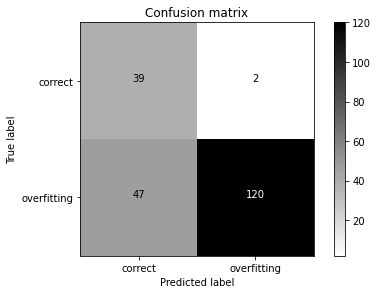

In [12]:
import xgboost as xgb
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  


Total train:  (8955, 204)
overfitting in train (6977, 204)
correct in train (1978, 204)
Total test:  (1347, 204)
overfitting in test (1322, 204)
correct in test (25, 204)
Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=449)
[0]	validation_0-mae:0.47401
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.42596
[2]	validation_0-mae:0.40332
[3]	validation_0-mae:0.40045
[4]	validation_0-mae:0.39066
[5]	validation_0-mae:0.38721
[6]	validation_0-mae:0.391

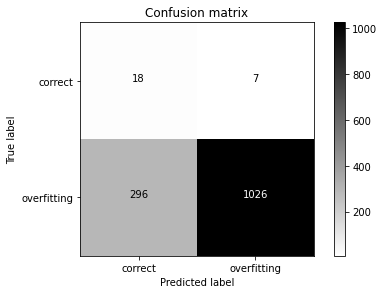

In [13]:
test =  totaltraining[ totaltraining['id'].str.contains(r'Chart')]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Chart')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  


Total train:  (9207, 204)
overfitting in train (7267, 204)
correct in train (1940, 204)
Total test:  (1095, 204)
overfitting in test (1032, 204)
correct in test (63, 204)
Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewArray', 'typeOfFaultyStmt_ NewClass',
       'typeOfFaultyStmt_ OperatorAssignment', 'typeOfFaultyStmt_ Parameter',
       'typeOfFaultyStmt_ Return', 'typeOfFaultyStmt_ Switch',
       'typeOfFaultyStmt_ Throw', 'typeOfFaultyStmt_ Try',
       'typeOfFaultyStmt_ TypeReference', 'typeOfFaultyStmt_ While'],
      dtype='object', length=445)
[0]	validation_0-mae:0.45771
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:0.43977
[2]	validation_0-mae:0.42973
[3]	validation_0-mae:0.42481
[4]	validation_0-mae:0.41161
[5]	validation_0-mae:0.41200
[6]	validation_0-mae:0.41117
[7

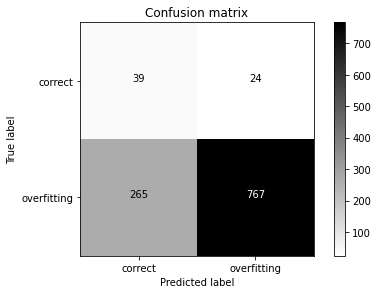

In [14]:
test =  totaltraining[ totaltraining['id'].str.contains(r'Lang')]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Lang')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=20, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  

Total train:  (9711, 204)
overfitting in train (7950, 204)
correct in train (1761, 204)
Total test:  (591, 204)
overfitting in test (349, 204)
correct in test (242, 204)
Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=444)
[0]	validation_0-mae:0.47533
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.43417
[2]	validation_0-mae:0.41984
[3]	validation_0-mae:0.40945
[4]	validation_0-mae:0.39735
[5]	validation_0-mae:0.38119
[6]	validation_0-mae:0.3869

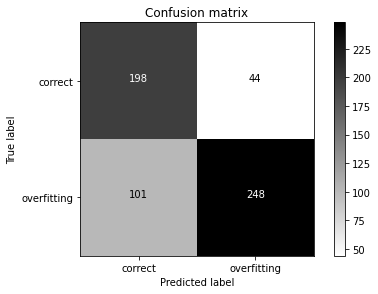

In [19]:
# Jackrabbit
test =  totaltraining[ totaltraining['id'].str.contains(r'ackrabbit')]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'ackrabbit')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  

Total train:  (9944, 204)
overfitting in train (8022, 204)
correct in train (1922, 204)
Total test:  (358, 204)
overfitting in test (277, 204)
correct in test (81, 204)
Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=447)
[0]	validation_0-mae:0.45111
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.40436
[2]	validation_0-mae:0.37999
[3]	validation_0-mae:0.35535
[4]	validation_0-mae:0.35887
[5]	validation_0-mae:0.35024
[6]	validation_0-mae:0.33886

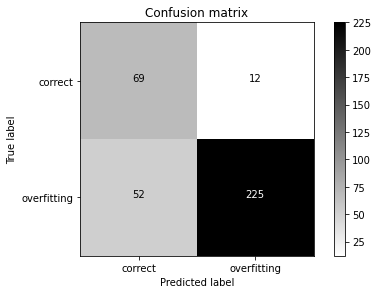

In [21]:
# Accumulo
test =  totaltraining[ totaltraining['id'].str.contains(r'ccumulo')]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'ccumulo')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  

Total train:  (10094, 204)
overfitting in train (8132, 204)
correct in train (1962, 204)
Total test:  (208, 204)
overfitting in test (167, 204)
correct in test (41, 204)
Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=448)
[0]	validation_0-mae:0.45576
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.50589
[2]	validation_0-mae:0.53598
[3]	validation_0-mae:0.55462
[4]	validation_0-mae:0.53331
[5]	validation_0-mae:0.49818
[6]	validation_0-mae:0.5373

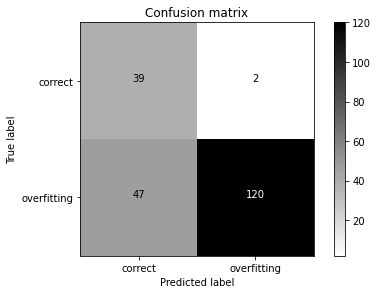

In [22]:
# Traccar
test =  totaltraining[ totaltraining['id'].str.contains(r'raccar')]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'raccar')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  

Total train:  (5408, 204)
overfitting in train (3625, 204)
correct in train (1783, 204)
Total test:  (4894, 204)
overfitting in test (4674, 204)
correct in test (220, 204)
Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=435)
[0]	validation_0-mae:0.47912
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.47091
[2]	validation_0-mae:0.45206
[3]	validation_0-mae:0.45016
[4]	validation_0-mae:0.43950
[5]	validation_0-mae:0.43382
[6]	validation_0-mae:0.43

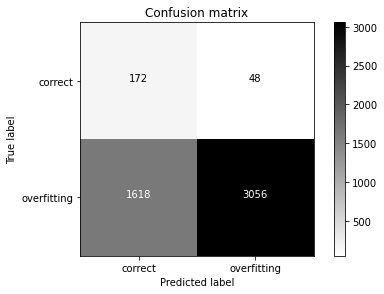

In [23]:
# Math
test =  totaltraining[ totaltraining['id'].str.contains(r'Math') |  totaltraining['id'].str.contains(r'math')]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Math') & ~ totaltraining['id'].str.contains(r'math')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  

Total train:  (10173, 204)
overfitting in train (8171, 204)
correct in train (2002, 204)
Total test:  (129, 204)
overfitting in test (128, 204)
correct in test (1, 204)
Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=450)
[0]	validation_0-mae:0.43700
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.37927
[2]	validation_0-mae:0.32664
[3]	validation_0-mae:0.27683
[4]	validation_0-mae:0.27118
[5]	validation_0-mae:0.24947
[6]	validation_0-mae:0.22700

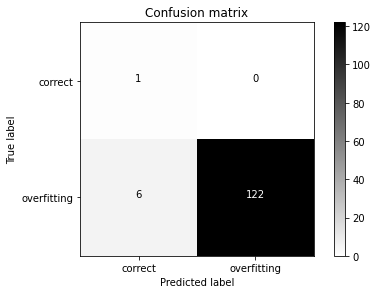

In [26]:
# Libra
test =  totaltraining[ totaltraining['id'].str.contains(r'libra') |  totaltraining['id'].str.contains(r'Bears_210')]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'libra') & ~ totaltraining['id'].str.contains(r'Bears_210')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  

Total train:  (10057, 204)
overfitting in train (8299, 204)
correct in train (1758, 204)
Total test:  (245, 204)
overfitting in test (0, 204)
correct in test (245, 204)
Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=450)
[0]	validation_0-mae:0.44627
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.40505
[2]	validation_0-mae:0.38036
[3]	validation_0-mae:0.37361
[4]	validation_0-mae:0.37361
[5]	validation_0-mae:0.35942
[6]	validation_0-mae:0.34711

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


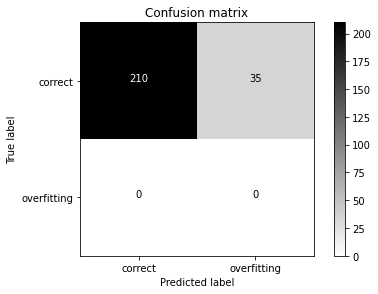

In [28]:
# Wicket
test =  totaltraining[ totaltraining['id'].str.contains(r'wicket') ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'wicket')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10130, 204)
overfitting in train (8299, 204)
correct in train (1831, 204)
Total test:  (172, 204)
overfitting in test (0, 204)
correct in test (172, 204)
Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=447)
[0]	validation_0-mae:0.50829
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.52058
[2]	validation_0-mae:0.52482
[3]	validation_0-mae:0.52039
[4]	validation_0-mae:0.52077
[5]	validation_0-mae:0.49947
[6]	validation_0-mae:0.50486

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


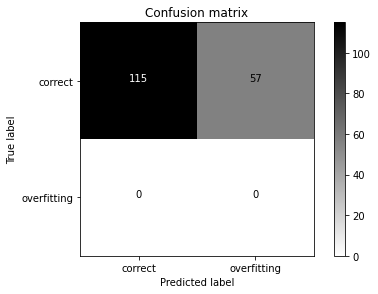

In [29]:
# Closure
test =  totaltraining[ totaltraining['id'].str.contains(r'Closure') ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Closure')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10178, 204)
overfitting in train (8299, 204)
correct in train (1879, 204)
Total test:  (124, 204)
overfitting in test (0, 204)
correct in test (124, 204)
[0]	validation_0-mae:0.44765
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:0.40897
[2]	validation_0-mae:0.38299
[3]	validation_0-mae:0.36491
[4]	validation_0-mae:0.35307
[5]	validation_0-mae:0.33267
[6]	validation_0-mae:0.32101
[7]	validation_0-mae:0.31014
[8]	validation_0-mae:0.30680
[9]	validation_0-mae:0.30457
[10]	validation_0-mae:0.30251
[11]	validation_0-mae:0.30033
[12]	validation_0-mae:0.29890
[13]	validation_0-mae:0.29841
[14]	validation_0-mae:0.29803
[15]	validation_0-mae:0.29457
[16]	validation_0-mae:0.28960
[17]	validation_0-mae:0.28823
[18]	validation_0-mae:0.28637
[19]	validation_0-mae:0.28433
[20]	validation_0-mae:0.27881
[21]	validation_0-mae:0.27627
[22]	validation_0-mae:0.27779
[23]	validation_0-mae:0.27706
[24]	validation_0-mae:0.27133
[25]	validation_0-mae:0.268

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


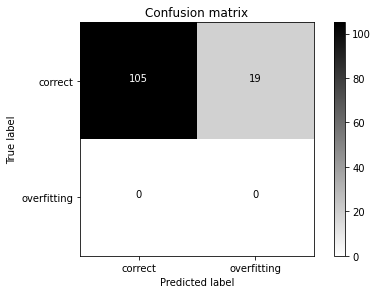

In [31]:
# Camel
test =  totaltraining[ totaltraining['id'].str.contains(r'camel') ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'camel')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10214, 204)
overfitting in train (8299, 204)
correct in train (1915, 204)
Total test:  (88, 204)
overfitting in test (0, 204)
correct in test (88, 204)
[0]	validation_0-mae:0.48785
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.47509
[2]	validation_0-mae:0.48995
[3]	validation_0-mae:0.45401
[4]	validation_0-mae:0.46021
[5]	validation_0-mae:0.44464
[6]	validation_0-mae:0.43120
[7]	validation_0-mae:0.43321
[8]	validation_0-mae:0.43885
[9]	validation_0-mae:0.42654
[10]	validation_0-mae:0.42424
[11]	validation_0-mae:0.42285
[12]	validation_0-mae:0.41853
[13]	validation_0-mae:0.41132
[14]	validation_0-mae:0.41744
[15]	validation_0-mae:0.42106
[16]	validation_0-mae:0.41442
[17]	validation_0-mae:0.41382
[18]	validation_0-mae:0.41149
[19]	validation_0-mae:0.41363
[20]	validation_0-mae:0.40660
[21]	validation_0-mae:0.40266
[22]	validation_0-mae:0.39265
[23]	validation_0-mae:0.38996
[24]	validation_0-mae:0.38816
[25]	validation_0-mae:0.37705

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


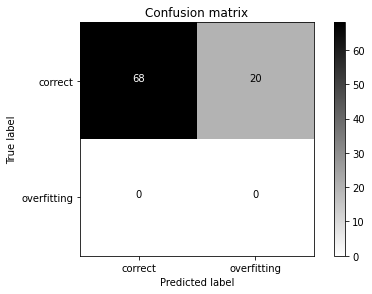

In [32]:
# Jsoup
test =  totaltraining[ totaltraining['id'].str.contains(r'Jsoup') ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Jsoup')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10230, 204)
overfitting in train (8299, 204)
correct in train (1931, 204)
Total test:  (72, 204)
overfitting in test (0, 204)
correct in test (72, 204)
[0]	validation_0-mae:0.42705
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.38372
[2]	validation_0-mae:0.34979
[3]	validation_0-mae:0.32594
[4]	validation_0-mae:0.30900
[5]	validation_0-mae:0.29686
[6]	validation_0-mae:0.28886
[7]	validation_0-mae:0.28248
[8]	validation_0-mae:0.28493
[9]	validation_0-mae:0.28375
[10]	validation_0-mae:0.28229
[11]	validation_0-mae:0.28105
[12]	validation_0-mae:0.27806
[13]	validation_0-mae:0.27094
[14]	validation_0-mae:0.26639
[15]	validation_0-mae:0.26649
[16]	validation_0-mae:0.26857
[17]	validation_0-mae:0.26193
[18]	validation_0-mae:0.25737
[19]	validation_0-mae:0.24963
[20]	validation_0-mae:0.24439
[21]	validation_0-mae:0.24358
[22]	validation_0-mae:0.24320
[23]	validation_0-mae:0.23861
[24]	validation_0-mae:0.23664
[25]	validation_0-mae:0.23098

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


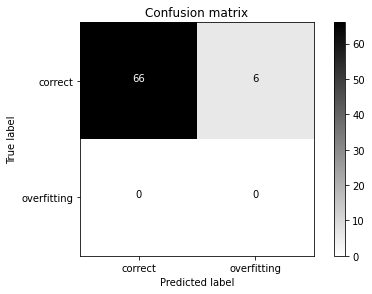

In [33]:
# Log4J
test =  totaltraining[ totaltraining['id'].str.contains(r'logging') ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'logging')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10260, 204)
overfitting in train (8299, 204)
correct in train (1961, 204)
Total test:  (42, 204)
overfitting in test (0, 204)
correct in test (42, 204)
[0]	validation_0-mae:0.43168
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.39348
[2]	validation_0-mae:0.35027
[3]	validation_0-mae:0.31253
[4]	validation_0-mae:0.29874
[5]	validation_0-mae:0.29437
[6]	validation_0-mae:0.28468
[7]	validation_0-mae:0.28059
[8]	validation_0-mae:0.27727
[9]	validation_0-mae:0.27089
[10]	validation_0-mae:0.26719
[11]	validation_0-mae:0.27259
[12]	validation_0-mae:0.26837
[13]	validation_0-mae:0.25578
[14]	validation_0-mae:0.25913
[15]	validation_0-mae:0.25594
[16]	validation_0-mae:0.25758
[17]	validation_0-mae:0.25989
[18]	validation_0-mae:0.25974
[19]	validation_0-mae:0.25911
[20]	validation_0-mae:0.25819
[21]	validation_0-mae:0.25643
[22]	validation_0-mae:0.25405
[23]	validation_0-mae:0.25232
[24]	validation_0-mae:0.25159
[25]	validation_0-mae:0.25098

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


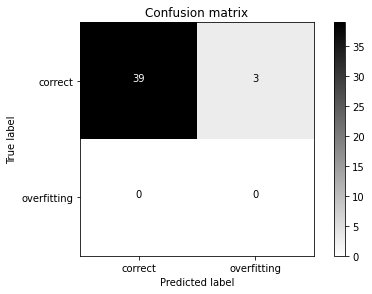

In [34]:
# Maven
test =  totaltraining[ totaltraining['id'].str.contains(r'maven') ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'maven')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10267, 204)
overfitting in train (8299, 204)
correct in train (1968, 204)
Total test:  (35, 204)
overfitting in test (0, 204)
correct in test (35, 204)
[0]	validation_0-mae:0.46384
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.45806
[2]	validation_0-mae:0.43431
[3]	validation_0-mae:0.42070
[4]	validation_0-mae:0.38533
[5]	validation_0-mae:0.38488
[6]	validation_0-mae:0.37535
[7]	validation_0-mae:0.37011
[8]	validation_0-mae:0.36108
[9]	validation_0-mae:0.36074
[10]	validation_0-mae:0.36706
[11]	validation_0-mae:0.35982
[12]	validation_0-mae:0.36276
[13]	validation_0-mae:0.35728
[14]	validation_0-mae:0.34835
[15]	validation_0-mae:0.35500
[16]	validation_0-mae:0.34710
[17]	validation_0-mae:0.34603
[18]	validation_0-mae:0.35092
[19]	validation_0-mae:0.35070
[20]	validation_0-mae:0.35180
[21]	validation_0-mae:0.35045
[22]	validation_0-mae:0.34750
[23]	validation_0-mae:0.34258
[24]	validation_0-mae:0.34235
[25]	validation_0-mae:0.34177

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


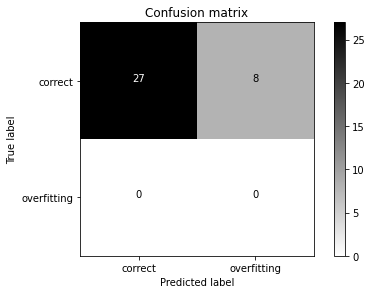

In [35]:
# Mockito
test =  totaltraining[ totaltraining['id'].str.contains(r'Mockito') ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Mockito')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10287, 204)
overfitting in train (8299, 204)
correct in train (1988, 204)
Total test:  (15, 204)
overfitting in test (0, 204)
correct in test (15, 204)
[0]	validation_0-mae:0.49617
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:0.48690
[2]	validation_0-mae:0.48625
[3]	validation_0-mae:0.45686
[4]	validation_0-mae:0.45289
[5]	validation_0-mae:0.46372
[6]	validation_0-mae:0.46235
[7]	validation_0-mae:0.47552
[8]	validation_0-mae:0.45440
[9]	validation_0-mae:0.44816
[10]	validation_0-mae:0.45398
[11]	validation_0-mae:0.45423
[12]	validation_0-mae:0.44052
[13]	validation_0-mae:0.45472
[14]	validation_0-mae:0.46177
[15]	validation_0-mae:0.46421
[16]	validation_0-mae:0.46782
[17]	validation_0-mae:0.46433
[18]	validation_0-mae:0.46256
[19]	validation_0-mae:0.45650
[20]	validation_0-mae:0.46493
[21]	validation_0-mae:0.46199
[22]	validation_0-mae:0.46533
[23]	validation_0-mae:0.46382
[24]	validation_0-mae:0.44200
[25]	validation_0-mae:0.43643

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


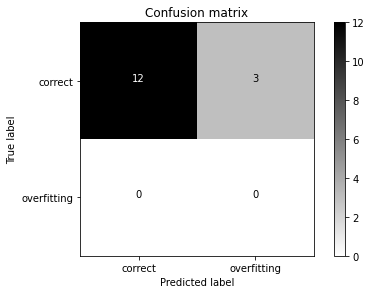

In [43]:
# Gson
test =  totaltraining[ totaltraining['id'].str.contains(r'Gson') ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Gson')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=20, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10285, 204)
overfitting in train (8299, 204)
correct in train (1986, 204)
Total test:  (17, 204)
overfitting in test (0, 204)
correct in test (17, 204)
[0]	validation_0-mae:0.48503
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.44640
[2]	validation_0-mae:0.44180
[3]	validation_0-mae:0.44234
[4]	validation_0-mae:0.42004
[5]	validation_0-mae:0.42380
[6]	validation_0-mae:0.41708
[7]	validation_0-mae:0.40906
[8]	validation_0-mae:0.40020
[9]	validation_0-mae:0.39620
[10]	validation_0-mae:0.38870
[11]	validation_0-mae:0.38082
[12]	validation_0-mae:0.38156
[13]	validation_0-mae:0.38444
[14]	validation_0-mae:0.37755
[15]	validation_0-mae:0.36835
[16]	validation_0-mae:0.35621
[17]	validation_0-mae:0.35894
[18]	validation_0-mae:0.35128
[19]	validation_0-mae:0.35227
[20]	validation_0-mae:0.34362
[21]	validation_0-mae:0.33607
[22]	validation_0-mae:0.33701
[23]	validation_0-mae:0.33239
[24]	validation_0-mae:0.33016
[25]	validation_0-mae:0.32458

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


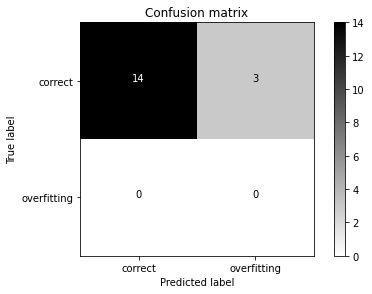

In [45]:
# Csv
test =  totaltraining[ totaltraining['id'].str.contains(r'Csv') ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Csv')]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10285, 204)
overfitting in train (8299, 204)
correct in train (1986, 204)
Total test:  (17, 204)
overfitting in test (0, 204)
correct in test (17, 204)
[0]	validation_0-mae:0.39491
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:0.33645
[2]	validation_0-mae:0.30014
[3]	validation_0-mae:0.25047
[4]	validation_0-mae:0.23385
[5]	validation_0-mae:0.22071
[6]	validation_0-mae:0.19577
[7]	validation_0-mae:0.17088
[8]	validation_0-mae:0.14643
[9]	validation_0-mae:0.14133
[10]	validation_0-mae:0.14305
[11]	validation_0-mae:0.14313
[12]	validation_0-mae:0.14267
[13]	validation_0-mae:0.13797
[14]	validation_0-mae:0.14045
[15]	validation_0-mae:0.13627
[16]	validation_0-mae:0.13198
[17]	validation_0-mae:0.12820
[18]	validation_0-mae:0.12638
[19]	validation_0-mae:0.12556
[20]	validation_0-mae:0.12245
[21]	validation_0-mae:0.11211
[22]	validation_0-mae:0.11315
[23]	validation_0-mae:0.11284
[24]	validation_0-mae:0.11258
[25]	validation_0-mae:0.11352

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


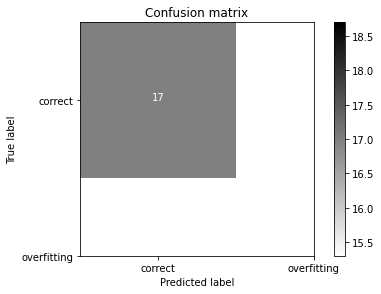

In [31]:
# Spring
test =  totaltraining[ totaltraining['id'].str.contains(r'Bears_180|Bears_181|Bears_182|Bears_183|Bears_184|Bears_185|Bears_84|Bears_85|Bears_86|Bears_87|Bears_88|Bears_89|Bears_90|Bears_91|Bears_92|Bears_93|Bears_94|Bears_95|Bears_96|Bears_97')   ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Bears_180|Bears_181|Bears_182|Bears_183|Bears_184|Bears_185|Bears_84|Bears_85|Bears_86|Bears_87|Bears_88|Bears_89|Bears_90|Bears_91|Bears_92|Bears_93|Bears_94|Bears_95|Bears_96|Bears_97')  ]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=20, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10284, 204)
overfitting in train (8299, 204)
correct in train (1985, 204)
Total test:  (18, 204)
overfitting in test (0, 204)
correct in test (18, 204)
[0]	validation_0-mae:0.46051
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.42211
[2]	validation_0-mae:0.41838
[3]	validation_0-mae:0.40995
[4]	validation_0-mae:0.39238
[5]	validation_0-mae:0.35801
[6]	validation_0-mae:0.35203
[7]	validation_0-mae:0.34876
[8]	validation_0-mae:0.35275
[9]	validation_0-mae:0.35339
[10]	validation_0-mae:0.33484
[11]	validation_0-mae:0.33754
[12]	validation_0-mae:0.34044
[13]	validation_0-mae:0.34176
[14]	validation_0-mae:0.32179
[15]	validation_0-mae:0.32094
[16]	validation_0-mae:0.31803
[17]	validation_0-mae:0.31865
[18]	validation_0-mae:0.31672
[19]	validation_0-mae:0.29712
[20]	validation_0-mae:0.30019
[21]	validation_0-mae:0.29489
[22]	validation_0-mae:0.29204
[23]	validation_0-mae:0.29074
[24]	validation_0-mae:0.28905
[25]	validation_0-mae:0.29187

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


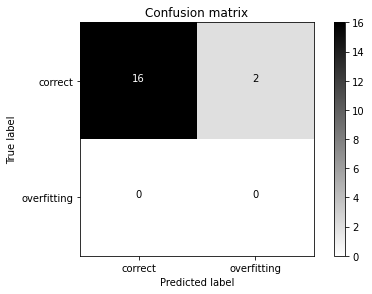

In [35]:
# jacksonxml
test =  totaltraining[ totaltraining['id'].str.contains(r'Bears_0_|Bears_1_|Bears_2_|Bears_3_|Bears_4_|Bears_5_|Bears_6_|Bears_7_|Bears_8_|Bears_9_|Bears_10_|Bears_11_|Bears_12_|Bears_13_|Bears_14_|Bears_15_|Bears_16_|Bears_17_|Bears_18_|JacksonXml')   ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Bears_0_|Bears_1_|Bears_2_|Bears_3_|Bears_4_|Bears_5_|Bears_6_|Bears_7_|Bears_8_|Bears_9_|Bears_10_|Bears_11_|Bears_12_|Bears_13_|Bears_14_|Bears_15_|Bears_16_|Bears_17_|Bears_18_|JacksonXml') ]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10252, 204)
overfitting in train (8299, 204)
correct in train (1953, 204)
Total test:  (50, 204)
overfitting in test (0, 204)
correct in test (50, 204)
[0]	validation_0-mae:0.42549
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.37195
[2]	validation_0-mae:0.33263
[3]	validation_0-mae:0.30580
[4]	validation_0-mae:0.28065
[5]	validation_0-mae:0.25677
[6]	validation_0-mae:0.23993
[7]	validation_0-mae:0.23300
[8]	validation_0-mae:0.22645
[9]	validation_0-mae:0.21557
[10]	validation_0-mae:0.20788
[11]	validation_0-mae:0.20428
[12]	validation_0-mae:0.20955
[13]	validation_0-mae:0.20178
[14]	validation_0-mae:0.20185
[15]	validation_0-mae:0.19475
[16]	validation_0-mae:0.19453
[17]	validation_0-mae:0.19082
[18]	validation_0-mae:0.18810
[19]	validation_0-mae:0.18001
[20]	validation_0-mae:0.18007
[21]	validation_0-mae:0.17665
[22]	validation_0-mae:0.17598
[23]	validation_0-mae:0.16639
[24]	validation_0-mae:0.16780
[25]	validation_0-mae:0.16700

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


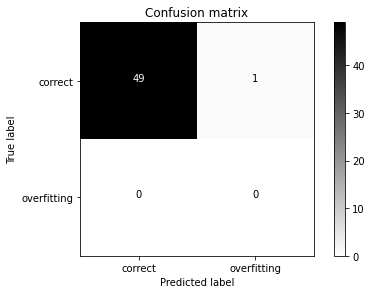

In [37]:
# Spoon
test =  totaltraining[ totaltraining['id'].str.contains(r'Bears_27|Bears_28|Bears_29|Bears_30|Bears_31|Bears_32|Bears_33|Bears_34|Bears_35|Bears_36|Bears_37|Bears_38|Bears_39|Bears_40|Bears_41|Bears_42|Bears_43|Bears_44|Bears_45|Bears_46|Bears_47|Bears_48|Bears_49|Bears_50|Bears_51|Bears_52|Bears_53|Bears_54|Bears_55|Bears_56|Bears_57|Bears_58|Bears_59|Bears_60|Bears_61|Bears_62|Bears_63|Bears_64|Bears_65|Bears_66|Bears_67|Bears_68|Bears_69|Bears_70|Bears_71|Bears_72|Bears_73|Bears_74|Bears_75|Bears_76|Bears_77|Bears_78|Bears_79|Bears_80|Bears_81|Bears_82|Bears_83|Bears_215|Bears_216|Bears_217|Bears_218|Bears_219')  ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Bears_27|Bears_28|Bears_29|Bears_30|Bears_31|Bears_32|Bears_33|Bears_34|Bears_35|Bears_36|Bears_37|Bears_38|Bears_39|Bears_40|Bears_41|Bears_42|Bears_43|Bears_44|Bears_45|Bears_46|Bears_47|Bears_48|Bears_49|Bears_50|Bears_51|Bears_52|Bears_53|Bears_54|Bears_55|Bears_56|Bears_57|Bears_58|Bears_59|Bears_60|Bears_61|Bears_62|Bears_63|Bears_64|Bears_65|Bears_66|Bears_67|Bears_68|Bears_69|Bears_70|Bears_71|Bears_72|Bears_73|Bears_74|Bears_75|Bears_76|Bears_77|Bears_78|Bears_79|Bears_80|Bears_81|Bears_82|Bears_83|Bears_215|Bears_216|Bears_217|Bears_218|Bears_219') ]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10295, 204)
overfitting in train (8299, 204)
correct in train (1996, 204)
Total test:  (7, 204)
overfitting in test (0, 204)
correct in test (7, 204)
[0]	validation_0-mae:0.49662
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:0.49177
[2]	validation_0-mae:0.44640
[3]	validation_0-mae:0.40748
[4]	validation_0-mae:0.37393
[5]	validation_0-mae:0.34591
[6]	validation_0-mae:0.31696
[7]	validation_0-mae:0.34298
[8]	validation_0-mae:0.32214
[9]	validation_0-mae:0.31080
[10]	validation_0-mae:0.31569
[11]	validation_0-mae:0.31279
[12]	validation_0-mae:0.30907
[13]	validation_0-mae:0.31315
[14]	validation_0-mae:0.33032
[15]	validation_0-mae:0.31721
[16]	validation_0-mae:0.32542
[17]	validation_0-mae:0.33441
[18]	validation_0-mae:0.33066
[19]	validation_0-mae:0.32639
[20]	validation_0-mae:0.32243
[21]	validation_0-mae:0.33095
[22]	validation_0-mae:0.30275
[23]	validation_0-mae:0.29984
[24]	validation_0-mae:0.33304
[25]	validation_0-mae:0.33221
[

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


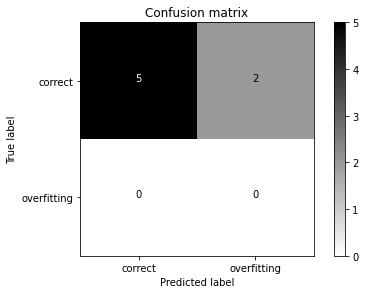

In [42]:
# incubator
test =  totaltraining[ totaltraining['id'].str.contains(r'Bears_149|Bears_150|Bears_151|Bears_152|Bears_153|Bears_154|Bears_195|Bears_196')  ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Bears_149|Bears_150|Bears_151|Bears_152|Bears_153|Bears_154|Bears_195|Bears_196') ]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=10, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10297, 204)
overfitting in train (8299, 204)
correct in train (1998, 204)
Total test:  (5, 204)
overfitting in test (0, 204)
correct in test (5, 204)
[0]	validation_0-mae:0.42839
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:0.37410
[2]	validation_0-mae:0.34547
[3]	validation_0-mae:0.32879
[4]	validation_0-mae:0.32538
[5]	validation_0-mae:0.33290
[6]	validation_0-mae:0.30290
[7]	validation_0-mae:0.27685
[8]	validation_0-mae:0.28681
[9]	validation_0-mae:0.29575
[10]	validation_0-mae:0.29169
[11]	validation_0-mae:0.28806
[12]	validation_0-mae:0.29637
[13]	validation_0-mae:0.31051
[14]	validation_0-mae:0.31554
[15]	validation_0-mae:0.29896
[16]	validation_0-mae:0.28593
[17]	validation_0-mae:0.28095
Stopping. Best iteration:
[7]	validation_0-mae:0.27685

f1 score: 1.0
acc score: 1.0
precision score: 0.0
recall score: 0.0


/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


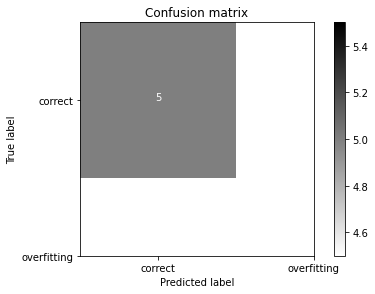

In [44]:
# fresco
test =  totaltraining[ totaltraining['id'].str.contains(r'Bears_144|Bears_145|Bears_146|Bears_147|Bears_148')  ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Bears_144|Bears_145|Bears_146|Bears_147|Bears_148')  ]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=10, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Total train:  (10297, 204)
overfitting in train (8299, 204)
correct in train (1998, 204)
Total test:  (5, 204)
overfitting in test (0, 204)
correct in test (5, 204)
[0]	validation_0-mae:0.43331
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.46985
[2]	validation_0-mae:0.40982
[3]	validation_0-mae:0.37225
[4]	validation_0-mae:0.35693
[5]	validation_0-mae:0.36239
[6]	validation_0-mae:0.36775
[7]	validation_0-mae:0.36969
[8]	validation_0-mae:0.37014
[9]	validation_0-mae:0.36029
[10]	validation_0-mae:0.35638
[11]	validation_0-mae:0.35536
[12]	validation_0-mae:0.33918
[13]	validation_0-mae:0.31952
[14]	validation_0-mae:0.32459
[15]	validation_0-mae:0.30053
[16]	validation_0-mae:0.28925
[17]	validation_0-mae:0.27429
[18]	validation_0-mae:0.27020
[19]	validation_0-mae:0.27218
[20]	validation_0-mae:0.27820
[21]	validation_0-mae:0.29231
[22]	validation_0-mae:0.28812
[23]	validation_0-mae:0.29539
[24]	validation_0-mae:0.29625
[25]	validation_0-mae:0.29479
[

/home/wasp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


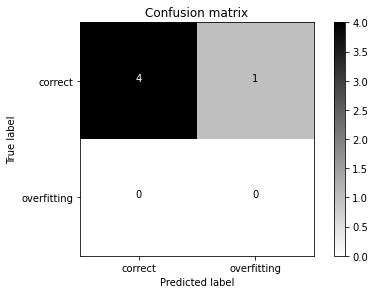

In [51]:
# molgenis
test =  totaltraining[ totaltraining['id'].str.contains(r'Bears_170|Bears_171|Bears_172|Bears_173|Bears_174|Bears_175')   ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Bears_170|Bears_171|Bears_172|Bears_173|Bears_174|Bears_175')   ]
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)


smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)


X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


model = xgb.XGBClassifier(random_state=42, max_depth=6, gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()